#Exam Anthea Silvia Sasdelli
##June 2023

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence. 





#Download of the libraries and the dataset




In [1]:
!pip install -q datasets
!pip3 install -q apache-beam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 5.8 MB/s et

In [2]:
import tensorflow as tf
tf.config.run_functions_eagerly(False)
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Embedding, Input, Reshape, Embedding, GRU, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Metric

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
import pickle
import gdown
import random
from random import Random

import nltk
from nltk.tokenize import sent_tokenize

import copy

from collections import OrderedDict
from tqdm import tqdm
from typing import List

# Plotting libraries
import matplotlib.pyplot as plt

In [3]:
# Instantiate the Random instance with random seed = 42 to ensure reproducibility
seed = 42
randomizer = Random(seed)

EMBEDDING_SIZE = 50

In [4]:
from datasets import load_dataset

dataset = load_dataset("wikipedia", "20220301.simple")

data = dataset['train'][:20000]['text']

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235M [00:00<?, ?B/s]

Dataset wikipedia downloaded and prepared to /root/.cache/huggingface/datasets/wikipedia/20220301.simple/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

##Tokenization of the dataset
Tokenization is an essential step because it breaks down text into smaller units called tokens. In this cell a new set of data is created (*original_data*), that correspond to the tokenized ordered data.

In [5]:
dump = True

tokenizer = Tokenizer(split=' ', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', num_words=10000, oov_token='<unk>')

corpus = []

# Split of each piece of text into sentences
for elem in data:
  corpus += elem.lower().replace("\n", "").split(".")[:]

print("corpus dim: ",len(corpus))

#add a start and an end token
corpus = ['<start> '+s+' <end>' for s in corpus]

# Tokenization	
tokenizer.fit_on_texts(corpus)

if dump:
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

original_data = [sen for sen in tokenizer.texts_to_sequences(corpus) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen))]

if dump:
    with open('original.pickle', 'wb') as handle:
        pickle.dump(original_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

print ("filtered sentences: ",len(original_data))

sos = tokenizer.word_index['<start>']
eos = tokenizer.word_index['<end>']

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

corpus dim:  510023
filtered sentences:  137301


##Normalization of the new tokenized dataset
Here the normalization of the data has been computed.
Normalizing the data is important to ensure equal treatment of features, improve convergence speed, stabilize gradients, and enhance regularization effectiveness.



In [6]:
vocab_size =len(tokenizer.word_index)+1

def normalize(data):
  normalized_data=[]
  for i in data:
    element=[]
    for j in i:
      element.append(j/vocab_size)
    normalized_data.append(element)
  return normalized_data


In [7]:
original_data = normalize(original_data)

Now it is possible to create the input data, by shuffling the *original_data*.

In [10]:
shuffled_data = [random.sample(s[1:-1],len(s)-2) for s in original_data]
shuffled_data = [[sos]+s+[eos] for s in shuffled_data]

##Splitting of the Original and Shuffled data into Train, Validation and Test

In [11]:
# Split the data into train, validation, and test sets
test_size=0.3
validation_size=0.25

x_train, x_test, y_train, y_test = train_test_split(
    shuffled_data, original_data, test_size=test_size, random_state=seed
)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=validation_size/(1-test_size), random_state=seed
)

In [12]:
def plot_sentence_lengths(train_sentences, val_sentences, title):
    # Calculate the lengths of train and validation sentences
    train_lengths = [len(sentence) for sentence in train_sentences]
    val_lengths = [len(sentence) for sentence in val_sentences]
    
    # Create a histogram of sentence lengths
    plt.hist([train_lengths, val_lengths], bins=20, label=['Train', 'Validation'])
    
    # Set the labels and title of the plot
    plt.xlabel('Sentence Length')
    plt.ylabel('Frequency')
    plt.title(title)
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.show()

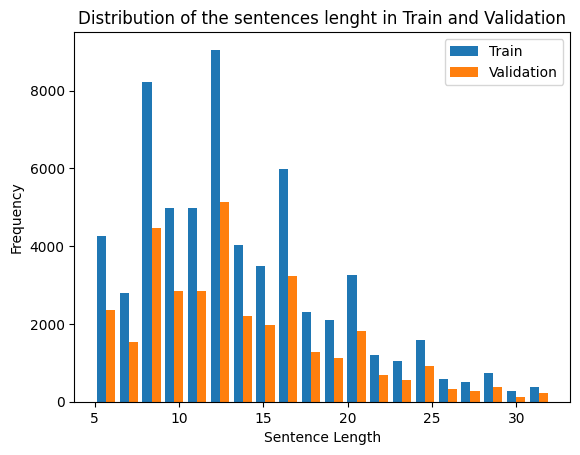

In [13]:
plot_sentence_lengths(x_train, x_val, 'Distribution of the sentences lenght in Train and Validation')

In [14]:
max_sequence_length = max(len(seq) for seq in x_train + x_val + x_test)

##Padding
Padding the data is important to ensure that all input sequences have the same length. This is necessary because the neural network require inputs of fixed dimensions.

In [15]:
# Pad sequences to a fixed length
input_seq_train = pad_sequences(x_train, maxlen=max_sequence_length, padding='post', dtype='float32')
input_seq_val = pad_sequences(x_val, maxlen=max_sequence_length, padding='post', dtype='float32')
input_seq_test = pad_sequences(x_test, maxlen=max_sequence_length, padding='post', dtype='float32')

target_seq_train = pad_sequences(y_train, maxlen=max_sequence_length, padding='post', dtype='float32')
target_seq_val = pad_sequences(y_val, maxlen=max_sequence_length, padding='post', dtype='float32')
target_seq_test = pad_sequences(y_test, maxlen=max_sequence_length, padding='post', dtype='float32')

#Implementation of the model

Early stopping has been used to prevent overfitting, save computational resources, and improve generalization by stopping the training process when the model's performance on a validation set starts to degrade. It helps find the optimal balance between underfitting and overfitting and ensures that the model performs well on unseen data.

In [37]:
# Define the Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

###Metrics

In [41]:
from difflib import SequenceMatcher

def compute_score(source_sequences, predictions):
    total_score = 0
    for source_seq, prediction_seq in zip(source_sequences, predictions):
        # Remove start and end tokens from the sequences
        source_seq = source_seq[1:-1]
        prediction_seq = prediction_seq[1:-1]

        # Convert the sequences from token indices to strings
        source_string = ' '.join(map(str, source_seq))
        prediction_string = ' '.join(map(str, prediction_seq))

        # Compute the score using the provided score function
        sequence_score = score(source_string, prediction_string)
        total_score += sequence_score

    # Compute the average score
    average_score = total_score / len(source_sequences)
    return average_score



def score(s, p):
    match = SequenceMatcher(None, s, p).find_longest_match()
    return match.size / len(s)



The first model that was chosen was without the embedding layer but the results of the score weren't very good.

In [17]:
def build_model2(vocab_size, max_sequence_length):
    input_sequence = Input(shape=(32,1))
    masked = tf.keras.layers.Masking(mask_value=0.0000000e+00)(input_sequence)
    l1 = BatchNormalization()(masked)
    lstm = LSTM(128, return_sequences=True, dropout=0.2)(l1)
    lstm = LSTM(64, return_sequences=True, dropout=0.2)(lstm)
    lstm = LSTM(32, return_sequences=True, dropout=0.2)(lstm)
    lstm = LSTM(32, return_sequences=False, dropout=0.2)(lstm)
    output = Activation('sigmoid')(lstm)
    model = Model(inputs=input_sequence, outputs=output)
    return model 
 

In [18]:
# Build the model
model1 = build_model2(vocab_size, max_sequence_length)

# Compile the model
model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer = Adam(2e-5), metrics = ['Accuracy'])

In [19]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 masking (Masking)           (None, 32, 1)             0         
                                                                 
 batch_normalization (BatchN  (None, 32, 1)            4         
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 32, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 32, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 32, 32)            12416     
                                                             

In [22]:
history = model1.fit(input_seq_train, target_seq_train, epochs=5, batch_size=32,
                    validation_data=(input_seq_val, target_seq_val), callbacks=[early_stopping])

Epoch 1/5
1931/1931 [==============================] - 336s 168ms/step - loss: 0.1539 - Accuracy: 0.0082 - val_loss: 0.1529 - val_Accuracy: 0.0027
Epoch 2/5
1931/1931 [==============================] - 311s 161ms/step - loss: 0.1530 - Accuracy: 0.0231 - val_loss: 0.1528 - val_Accuracy: 0.0027
Epoch 3/5
1931/1931 [==============================] - 320s 166ms/step - loss: 0.1530 - Accuracy: 0.0243 - val_loss: 0.1527 - val_Accuracy: 0.0042
Epoch 4/5
1931/1931 [==============================] - 318s 165ms/step - loss: 0.1529 - Accuracy: 0.0232 - val_loss: 0.1527 - val_Accuracy: 0.0042
Epoch 5/5
1931/1931 [==============================] - 371s 192ms/step - loss: 0.1529 - Accuracy: 0.0231 - val_loss: 0.1527 - val_Accuracy: 0.0027


In [27]:
predictions2 = model1.predict(input_seq_test)

def clean(predictions, y_test):
    pred = []
    for i, seq in zip(predictions, y_test):
        cleaned_seq = []
        for j, token in zip(i, seq):
            if token != 0:
                cleaned_seq.append(j)
        pred.append(cleaned_seq)
    return pred

cleaned_predictions2 = clean(predictions2, y_test)

# Compute the score
score2 = compute_score(y_test, cleaned_predictions2)

print("Score second model:", score2)

Score second model: 0.020646551594376464


##Model with an Embedding Layer
The model that produced the best result had an Embedding layer.
This layer is useful as it reduces word dimensionality, captures semantic relationships, encodes context, generalizes to unseen words, and improves learning with limited data.

The network contains:


*   Input layer 
*   The embedding layer
*   the mask layer to ignore the padded tokens
*   the GRU (Gated Recurrent Unit) layer
*   the dense layer with ReLU as activation function
*   the output layer with Softmax as activation function







In [28]:
def build_model5(vocab_size, max_sequence_length):
    input_sequence = Input(shape=(max_sequence_length,))
    embedding = Embedding(vocab_size, 50, input_length=max_sequence_length)(input_sequence)
    masked_embedding = tf.keras.layers.Masking(mask_value=0.0000000e+00)(embedding) #to make the NN ignore the padded tokens
    gru = GRU(64)(masked_embedding)
    dense = Dense(32, activation='relu')(gru)
    output = Dense(32, activation='softmax')(dense)
    model = Model(inputs=input_sequence, outputs=output)
    return model

In [29]:
# Build the model
model5 = build_model5(vocab_size, max_sequence_length)

# Compile the model
model5.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer = Adam(2e-5), metrics = ['Accuracy'])

In [30]:
model5.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 embedding (Embedding)       (None, 32, 50)            13578700  
                                                                 
 masking_1 (Masking)         (None, 32, 50)            0         
                                                                 
 gru (GRU)                   (None, 64)                22272     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
Total params: 13,604,108
Trainable params: 13,604,108
Non-t

In [31]:
history = model5.fit(input_seq_train, target_seq_train, epochs=5, validation_data=(input_seq_val, target_seq_val), callbacks=[early_stopping])

Epoch 1/5
1931/1931 [==============================] - 683s 351ms/step - loss: 0.1754 - Accuracy: 0.0045 - val_loss: 0.1896 - val_Accuracy: 0.0042
Epoch 2/5
1931/1931 [==============================] - 689s 357ms/step - loss: 0.1927 - Accuracy: 0.0038 - val_loss: 0.1951 - val_Accuracy: 0.0042
Epoch 3/5
1931/1931 [==============================] - 702s 363ms/step - loss: 0.1964 - Accuracy: 0.0038 - val_loss: 0.1972 - val_Accuracy: 0.0042
Epoch 4/5
1931/1931 [==============================] - 684s 354ms/step - loss: 0.1975 - Accuracy: 0.0038 - val_loss: 0.1976 - val_Accuracy: 0.0042


In [34]:
predictions5 = model5.predict(input_seq_test)

def clean(predictions, y_test):
    pred = []
    for i, seq in zip(predictions, y_test):
        cleaned_seq = []
        for j, token in zip(i, seq):
            if token != 0:
                cleaned_seq.append(j)
        pred.append(cleaned_seq)
    return pred

cleaned_predictions = clean(predictions5, y_test)

# Compute the score
score5 = compute_score(y_test, cleaned_predictions)

print("Score fifth model:", score5)

1288/1288 [==============================] - 10s 7ms/step
Score fifth model: 0.030185486131975418


The best score that was possible to find is 0.03.

##Weights of the model

In [45]:
# Get the weights of the model
weights = model5.get_weights()

weights[0]

array([[-0.02920223, -0.03744774, -0.06660609, ..., -0.04695489,
        -0.03968724, -0.02790933],
       [-0.04638932, -0.03118297,  0.0089724 , ..., -0.0160414 ,
         0.02579573,  0.04282253],
       [-0.04544911, -0.03017134,  0.02020629, ...,  0.01303993,
        -0.0315164 ,  0.01209712],
       ...,
       [-0.03596064, -0.02082239, -0.01536938, ..., -0.00542618,
        -0.00567504,  0.03847891],
       [-0.03618879,  0.0428384 ,  0.04310555, ..., -0.01198059,
         0.0301866 ,  0.00622138],
       [-0.02320538,  0.04917504, -0.04511148, ..., -0.00887424,
        -0.04389362,  0.01162919]], dtype=float32)

#Further improvements
Although the chosen model is the best among the various attempts that have been made, the resulting score is not very high.
Some improvements can be made:


*   the epochs have been diminished due to time restrictions. In order to have better results the number of epochs can be increased.
*   the composition of the network can be modified, by adding other layers to the model. Some attemps were done but due to limitations of time and processor availability some networks were discarded.
*   another solution to improve the score could be to retransform the padded, normalized and tokenized data into strings, in order to be able to compute the simple score function and have more precise results.
